
<img src="../images/5thNRST_logo.png" alt="NOWPAP" width="900" height="700">

## NOWPAP REMOTE SENSING TRAINING COURSE   
#### Webinar 2: Monitoring and Assessment of Water Quality by Ocean Color Remote Sensing
<span style="color:brown; font-size:1.1em;font-style:italic">Time series analysis: data download</span>

<hr style="border:2px solid rgb(30,70,125)"> </hr>

<span style="font-family:Helvieta; font-size:2em;">Genki Terauchi and Eligio Maure </span>

<span style="font-family:Helvieta; font-size:1em;">Please contact terauchi@npec.or.jp for inquiries. </span>

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Define parameters](#3.-Define-parameters)
- [4. Data preallocation](#4.-Data-preallocation)
- [5. Create the composite](#5.-Create-the-composite)
- [6. Display the result](#6.-Display-the-result)
- [7. Save the result](#7.-Save-the-result)
- [8. Resources](#8.-Resources)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

The objective of this exercise is to create composite images from a series of other satellite images obtained in the [Marine Environmental Watch](https://ocean.nowpap3.go.jp/?page_id=862) of Northwest Pacific Action Plan (NOWPAP).

You will learn how to read, composite and display the result of your composite image.
***

# 2. Library import
[Return to the "Table of contents"](#Table-of-contents)

In [22]:
# Data manipulation
import numpy as np #import ???? as name "np"
from netCDF4 import Dataset #Import Dataset library in netCDF4 module

# System
import sys #Import basic..
from pathlib import Path #Import Path library in pathlib module

# Visualization
import matplotlib.pyplot as plt #Import pyplot library in matplotlib
from matplotlib import colors, ticker # Import colors and tickers in matplotlib

import warnings #Import library to control warning messages
warnings.filterwarnings('ignore') #Import library to control warning messages

%matplotlib inline


In [23]:
sys.path.append(str(Path('.').absolute().parent)) ##Get current path location
import sutilsx as util #Import NPEC prepared utilities to process and analyze images

# 3. Define parameters
[Return to the "Table of contents"](#Table-of-contents)

In [24]:
VAR = 'chlor_a'    # variable name
COMP = 'month'   # composite period ('day', 'month', 'year')

INTPUT_DIR = Path('.').absolute().joinpath(r'data/SGLI/day')
OUTPUT_DIR = Path('.').absolute().joinpath(r'data/SGLI/month')
if not OUTPUT_DIR.is_dir():
    OUTPUT_DIR.mkdir(parents=True)

INPUT_FILES = list(INTPUT_DIR.glob('*.nc')) #Specifing files for composite
#INPUT_FILES

# 4. Data preallocation
[Return to the "Table of contents"](#Table-of-contents)
- Define a function to preallocate memory for the composite

In [25]:
def preallocate(file: Path, varname: str, t: int):   #Defining function to prepare empty data allay 
    with Dataset(file, 'r') as nc:
        shape = np.ma.squeeze(nc[varname][:]).shape
    shape = (t,) + shape
    return np.ma.empty(shape=shape, dtype=np.float32)

# 5. Create the composite
[Return to the "Table of contents"](#Table-of-contents)

In [26]:
nc = Dataset(INPUT_FILES[0], 'r') #Chekcing variable keynames in netCDF file 
nc.variables.keys()

dict_keys(['time', 'crs', 'lat', 'lon', 'chlor_a'])

In [27]:
%%time

# preallocate 
file = INPUT_FILES[0] # We need a file to get the shape of data
t = len(INPUT_FILES) # we need to count the number of files to composite
data = preallocate(file=file, t=t, varname=VAR) #data here is an emtpy data ally predifined by preallocate for monthly composite

for i, f in enumerate(INPUT_FILES): #For displaying progress bar 
    block = int(50 * (i + 1) // t)
    bar = '█' * block + '-' * (50 - block)
    print(f'\rDay {i + 1:2} {(100 * (i + 1) / t):.1f}% |{bar}| {i+1}/{t}', end='')
    
    with Dataset(f, 'r') as nc: #For aggregating variable values defined by VAR, in this case chlor_a
        sds = nc[VAR][:]
        data[i, :, :] = np.ma.log10(sds)

count = data.count(axis=0) #For counting number of valid pixels
count = np.ma.masked_where(count == 0, count) 
np.ma.set_fill_value(count, fill_value=sds.fill_value)

mean = data.mean(axis=0).astype(np.float32) #For making monthly mean data
mean = np.ma.power(10, mean)
np.ma.set_fill_value(mean, fill_value=sds.fill_value)
    
print(f'\nComposite done!')

Day 30 100.0% |██████████████████████████████████████████████████| 30/30
Composite done!
CPU times: user 477 ms, sys: 22.4 ms, total: 500 ms
Wall time: 505 ms


# 6. Display the result
[Return to the "Table of contents"](#Table-of-contents)
- Use matplotlib to display the composite image (we display both composite and count)

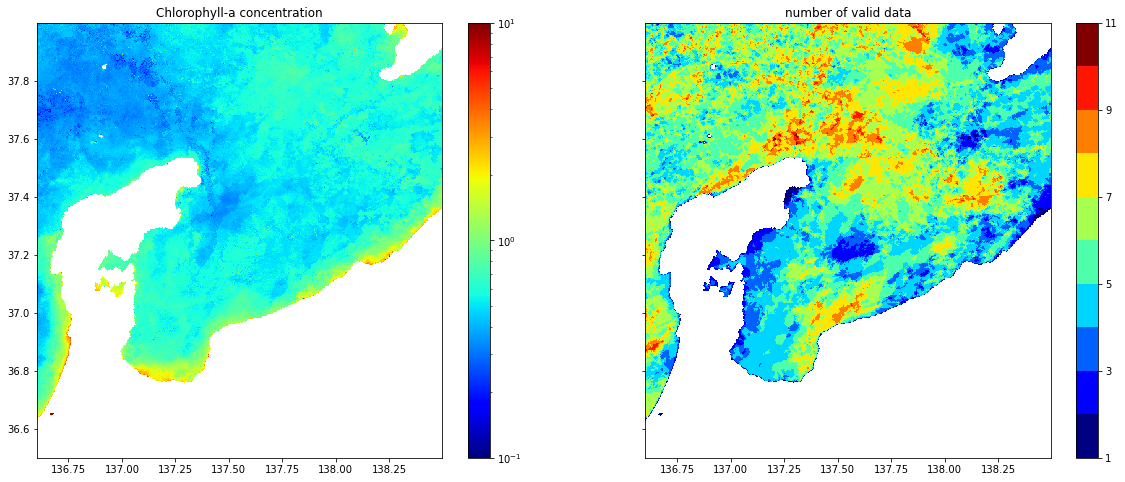

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,8), sharey=True) #Creating a figure with two subplots uisng plt.sublopts() function.

with Dataset(file, 'r') as nc: #Reading lattitude and longitute from netCDF files.
    lat = nc['lat'][:]
    lon = nc['lon'][:]

# LogNorm for chlorophyll data 
norm = colors.LogNorm(vmin=0.1, vmax=10)
m1 = ax[0].pcolormesh(lon, lat, mean, cmap='jet', norm=norm)

# Linear scale for count data
nbins = count.max() - count.min() 
levels = ticker.MaxNLocator(nbins=nbins).tick_values(count.min(), count.max())
norm = colors.BoundaryNorm(levels, ncolors=256, clip=True)
m2 = ax[1].pcolormesh(lon, lat, count, cmap='jet', norm=norm)

ax[0].set_title('Chlorophyll-a concentration')
plt.colorbar(m1, ax=ax[0], orientation='vertical')
ax[1].set_title('number of valid data')
plt.colorbar(m2, ax=ax[1], orientation='vertical')


# 7. Save the result 
[Return to the "Table of contents"](#Table-of-contents)

In [30]:
%%time
# Create a filename to save the data
save = OUTPUT_DIR.joinpath('GS202004_CHL_TB_month.nc')

util.nc_write(
    file=save
    , data=mean
    , varname=VAR
    , lon=lon
    , lat=lat
    , count=count)

NCWRITE: GS202004_CHL_TB_month | Elapsed:  0 hours  0 minutes 0.085 seconds
CPU times: user 82.6 ms, sys: 3.64 ms, total: 86.2 ms
Wall time: 85.6 ms


<div class="alert alert-block alert-success"/div>
    <b>Done!</b><br>
  
--- 

#### And thank you for your attention! :) 
    Now try the same exercise with other months or sensors, etc.
    We hope you enjoyed the training provided by NOWPAP CEARAC.

# 8. Resources
[Go back to the "Table of contents"](#Table-of-contents)
1. https://unidata.github.io/netcdf4-python/
2. https://matplotlib.org/
3. https://ocean.nowpap3.go.jp/?page_id=2345
4. https://github.com/npec/5th-NOWPAP-Training-Course-on-Remote-Sensing-Data-Analysis